In [18]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

In [19]:
def marginOfError(model):
  test_pred = model.predict(X_test)
  train_pred = model.predict(X_train)

  testCounts = getErrorMargins(y_test, test_pred)
  trainCounts = getErrorMargins(y_train, train_pred)

  plt.plot(range(30), testCounts, label = "Training Set")
  plt.title("Final Position Margin of Error")
  plt.xlabel("Margin of Error (Positions)")
  plt.ylabel("Proportion Correct")

  plt.plot(range(30), trainCounts, label = "Testing Set")
  plt.xlabel("Margin of Error (Positions)")
  plt.ylabel("Proportion Correct")
  plt.legend()
  plt.show()

In [21]:
def getErrorMargins(y_actual, y_pred):
    counts = np.zeros(30)
    y = y_actual.values
    total = len(y)

    diff = np.zeros(total)
    for index in range(total):
        temp = abs(y[index] - y_pred[index])
        diff[index] = abs(y[index] - y_pred[index])

    for val in diff:
        for index in range(len(counts)):
            if val < index:
                counts[index] += 1

    x = sum(diff)/total
    counts = counts/total
    return counts

Epoch 1/200
135/135 [==============================] - 3s 7ms/step - loss: 18.6919 - mae: 18.6919 - val_loss: 17.1687 - val_mae: 17.1687
Epoch 2/200
135/135 [==============================] - 1s 5ms/step - loss: 13.1044 - mae: 13.1044 - val_loss: 9.0986 - val_mae: 9.0986
Epoch 3/200
135/135 [==============================] - 1s 5ms/step - loss: 10.9716 - mae: 10.9716 - val_loss: 8.9494 - val_mae: 8.9494
Epoch 4/200
135/135 [==============================] - 1s 6ms/step - loss: 10.5113 - mae: 10.5113 - val_loss: 8.7075 - val_mae: 8.7075
Epoch 5/200
135/135 [==============================] - 1s 5ms/step - loss: 9.9005 - mae: 9.9005 - val_loss: 8.2373 - val_mae: 8.2373
Epoch 6/200
135/135 [==============================] - 1s 5ms/step - loss: 9.7876 - mae: 9.7876 - val_loss: 8.0394 - val_mae: 8.0394
Epoch 7/200
135/135 [==============================] - 1s 5ms/step - loss: 9.5901 - mae: 9.5901 - val_loss: 8.3890 - val_mae: 8.3890
Epoch 8/200
135/135 [==============================] - 1s 5

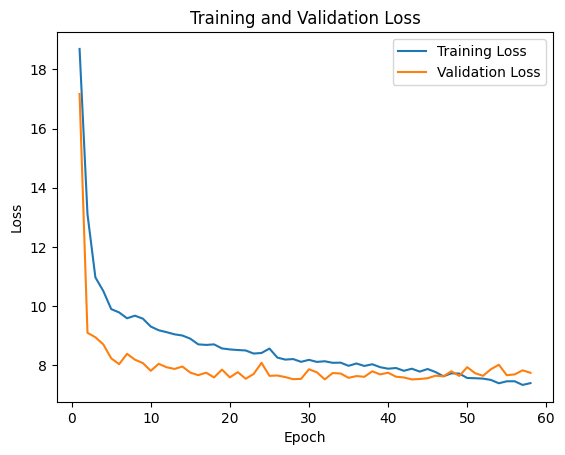

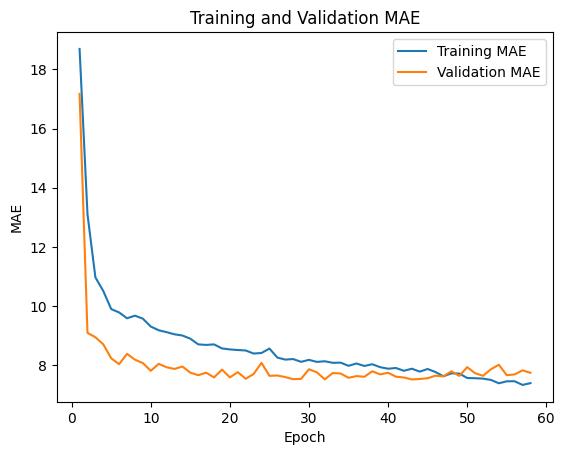

135/135 [==============================] - 0s 2ms/step
7.524042743223685
6.320241759694688


<ipython-input-11-5334a25dd46c>:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  diff[index] = abs(y[index] - y_pred[index])


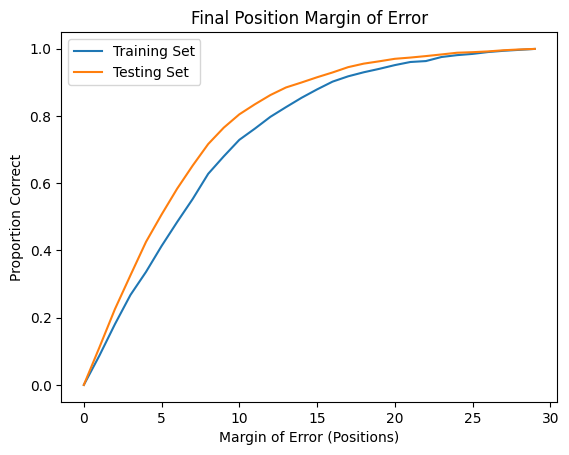

In [15]:
#Loads the dataset from github
data = pd.read_csv("https://raw.githubusercontent.com/ML-Racer-Performance-Prediction/NASCAR/main/Documentation/NASCAR%20Full%20Stats.csv")

# Separates the features and target
X = data.drop('EndingPosition', axis=1)
Y = data['EndingPosition']

# One-hot encoding the categorical features
categorical_cols = ['Track', 'Driver', 'Sponsor/Owner', 'CarManufacturer', 'TrackType']
numerical_cols = ['StartingPosition', 'CarNumber']

label_encoder = LabelEncoder()
for col in categorical_cols:
    X[col] = label_encoder.fit_transform(X[col])

categorical_transformer = OneHotEncoder(handle_unknown='ignore')
categorical_transformer = categorical_transformer.fit(X[categorical_cols])
X_categorical = categorical_transformer.transform(X[categorical_cols]).toarray()

# Feature scaling on numerical features
numerical_transformer = StandardScaler()
X_numerical = numerical_transformer.fit_transform(X[numerical_cols])

# Combines the categorical and numerical features together again
X_combined = pd.concat([pd.DataFrame(X_categorical), pd.DataFrame(X_numerical)], axis=1)

# Splits the dataset. 80% for training, 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X_combined, Y, test_size=0.2, random_state=14)

# Build the MLP model. ReLU activation, 40% dropout, 4 hidden layers
MLP = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.4),
    Dense(64, activation='relu'),
    Dropout(0.4),
    Dense(32, activation='relu'),
    Dropout(0.4),
    Dense(16, activation='relu'),
    Dropout(0.4),
    Dense(1, activation='relu')
])

# Compiles the model with SGD, lr of 0.001, and a momentum of 0.8
optimizer = SGD(learning_rate=0.001, momentum=0.8)
MLP.compile(optimizer=optimizer, loss='mae', metrics=['mae'])

# Early stopping to prevent overfitting
stop_early = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Training the model with a batch size of 32 and maximum of 200 epochs
history = MLP.fit(X_train, y_train, epochs=200, batch_size=32, validation_data=(X_test, y_test), callbacks=[stop_early])

# Gets the loss histories
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_mae = history.history['mae']
val_mae = history.history['val_mae']

# Evaluates the model on the test set
test_loss = MLP.evaluate(X_test, y_test, verbose=0)
print(f'Test MAE: {test_loss}')

# Makes predictions
y_pred = MLP.predict(X_test)

# Calculates MAE, MSE, and R-squared, then prints results
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

# Plots the training and validation loss
plt.figure()
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plots the training and validation MAE
plt.figure()
plt.plot(range(1, len(train_mae) + 1), train_mae, label='Training MAE')
plt.plot(range(1, len(val_mae) + 1), val_mae, label='Validation MAE')
plt.title('Training and Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.show()

plt.figure()
marginOfError(MLP)

Epoch 1/200
135/135 [==============================] - 1s 4ms/step - loss: 18.7910 - mae: 18.7910 - val_loss: 18.2821 - val_mae: 18.2821
Epoch 2/200
135/135 [==============================] - 0s 2ms/step - loss: 17.5673 - mae: 17.5673 - val_loss: 17.1412 - val_mae: 17.1412
Epoch 3/200
135/135 [==============================] - 0s 2ms/step - loss: 16.4835 - mae: 16.4835 - val_loss: 16.1223 - val_mae: 16.1223
Epoch 4/200
135/135 [==============================] - 0s 2ms/step - loss: 15.5291 - mae: 15.5291 - val_loss: 15.2175 - val_mae: 15.2175
Epoch 5/200
135/135 [==============================] - 0s 2ms/step - loss: 14.6798 - mae: 14.6798 - val_loss: 14.4051 - val_mae: 14.4051
Epoch 6/200
135/135 [==============================] - 0s 2ms/step - loss: 13.9218 - mae: 13.9218 - val_loss: 13.6707 - val_mae: 13.6707
Epoch 7/200
135/135 [==============================] - 0s 2ms/step - loss: 13.2458 - mae: 13.2458 - val_loss: 13.0207 - val_mae: 13.0207
Epoch 8/200
135/135 [====================

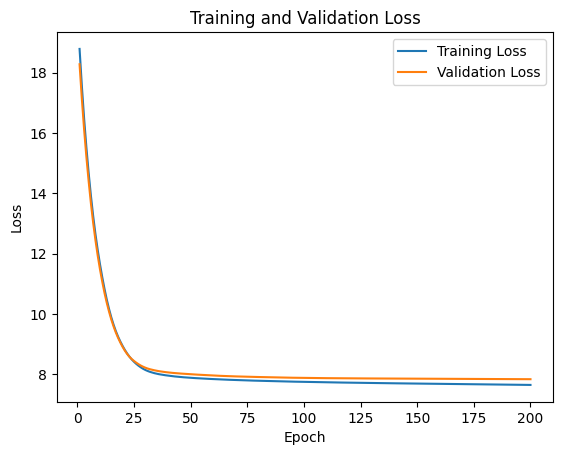

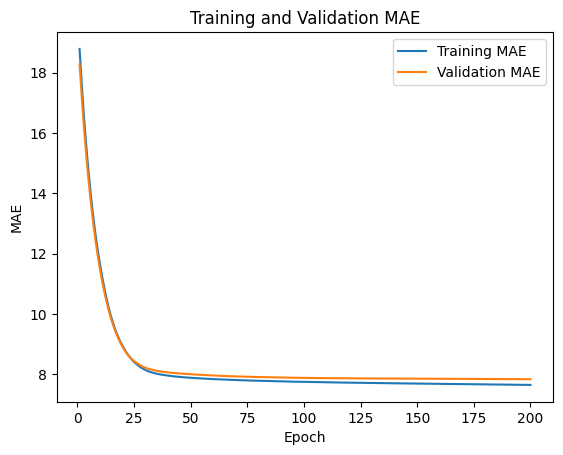

135/135 [==============================] - 0s 1ms/step
7.828978252410889
7.638009791796049


<ipython-input-11-5334a25dd46c>:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  diff[index] = abs(y[index] - y_pred[index])


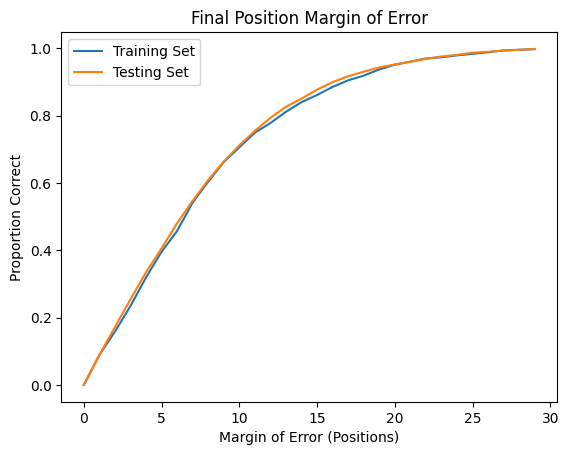

In [16]:
# Build the Linear Regression model using a Single-Layer Perceptron with relu activation
LinReg = Sequential([
    Dense(1, activation='relu', input_shape=(X_train.shape[1],))
])
# Compiles the model with SGD, lr of 0.001, and a momentum of 0.8
optimizer = SGD(learning_rate=0.001, momentum=0.8)
LinReg.compile(optimizer=optimizer, loss='mae', metrics=['mae'])

# Early stopping to prevent overfitting
stop_early = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Training the model with a batch size of 32 and maximum of 200 epochs
history = LinReg.fit(X_train, y_train, epochs=200, batch_size=32, validation_data=(X_test, y_test), callbacks=[stop_early])

# Gets the loss histories
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_mae = history.history['mae']
val_mae = history.history['val_mae']

# Evaluates the model on the test set
test_loss = LinReg.evaluate(X_test, y_test, verbose=0)
print(f'Test MAE: {test_loss}')

# Makes predictions
y_pred = LinReg.predict(X_test)

# Calculates MAE, MSE, and R-squared, then prints results
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

# Plots the training and validation loss
plt.figure()
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plots the training and validation MAE
plt.figure()
plt.plot(range(1, len(train_mae) + 1), train_mae, label='Training MAE')
plt.plot(range(1, len(val_mae) + 1), val_mae, label='Validation MAE')
plt.title('Training and Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.show()

plt.figure()
marginOfError(LinReg)

Epoch 1/200
135/135 [==============================] - 1s 5ms/step - loss: 18.2213 - mae: 18.2213 - val_loss: 16.3520 - val_mae: 16.3520
Epoch 2/200
135/135 [==============================] - 0s 3ms/step - loss: 11.8893 - mae: 11.8893 - val_loss: 8.4643 - val_mae: 8.4643
Epoch 3/200
135/135 [==============================] - 0s 3ms/step - loss: 9.1474 - mae: 9.1474 - val_loss: 8.0437 - val_mae: 8.0437
Epoch 4/200
135/135 [==============================] - 0s 3ms/step - loss: 9.0040 - mae: 9.0040 - val_loss: 8.0342 - val_mae: 8.0342
Epoch 5/200
135/135 [==============================] - 0s 3ms/step - loss: 8.7690 - mae: 8.7690 - val_loss: 7.9232 - val_mae: 7.9232
Epoch 6/200
135/135 [==============================] - 0s 3ms/step - loss: 8.6713 - mae: 8.6713 - val_loss: 8.0989 - val_mae: 8.0989
Epoch 7/200
135/135 [==============================] - 0s 3ms/step - loss: 8.6459 - mae: 8.6459 - val_loss: 7.9325 - val_mae: 7.9325
Epoch 8/200
135/135 [==============================] - 0s 3ms/s

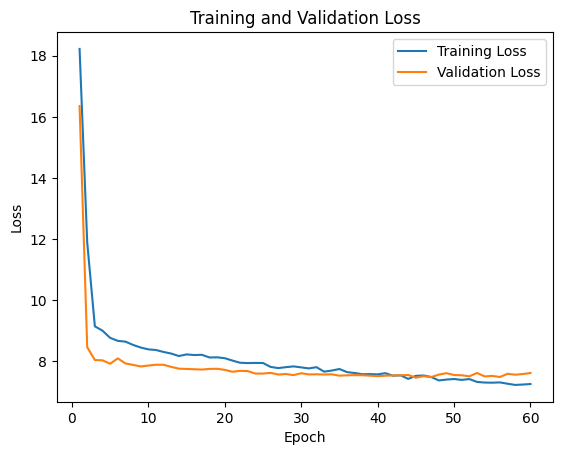

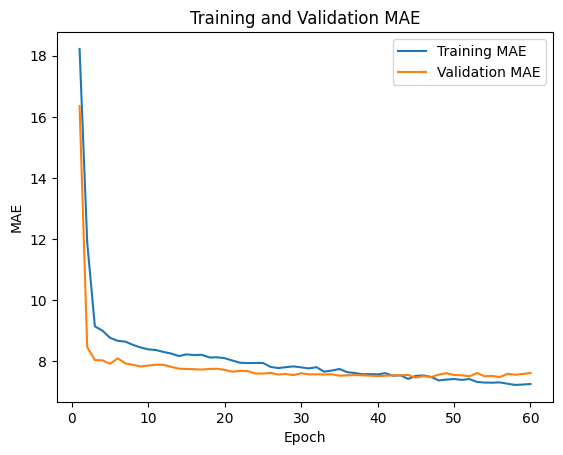

135/135 [==============================] - 0s 2ms/step


<ipython-input-11-5334a25dd46c>:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  diff[index] = abs(y[index] - y_pred[index])


7.467328005366856
6.755120005415456


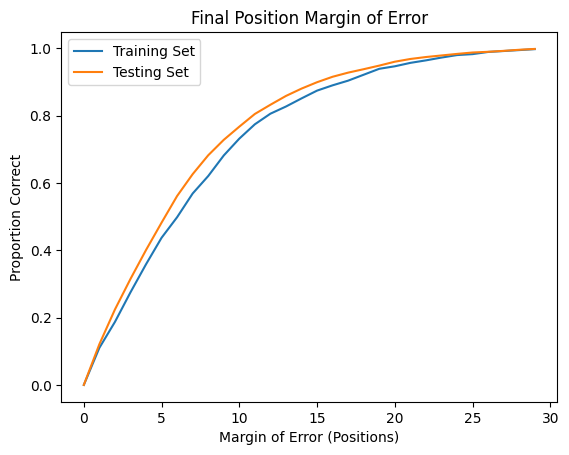

In [17]:
# Build the Linear Regression model using a Single-Layer Perceptron with relu activation
MLP_Small = Sequential([
    Dense(32, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='relu')
])
# Compiles the model with SGD, lr of 0.001, and a momentum of 0.8
optimizer = SGD(learning_rate=0.001, momentum=0.8)
MLP_Small.compile(optimizer=optimizer, loss='mae', metrics=['mae'])

# Early stopping to prevent overfitting
stop_early = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Training the model with a batch size of 32 and maximum of 200 epochs
history = MLP_Small.fit(X_train, y_train, epochs=200, batch_size=32, validation_data=(X_test, y_test), callbacks=[stop_early])

# Gets the loss histories
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_mae = history.history['mae']
val_mae = history.history['val_mae']

# Evaluates the model on the test set
test_loss = MLP_Small.evaluate(X_test, y_test, verbose=0)
print(f'Test MAE: {test_loss}')

# Makes predictions
y_pred = MLP_Small.predict(X_test)

# Calculates MAE, MSE, and R-squared, then prints results
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

# Plots the training and validation loss
plt.figure()
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plots the training and validation MAE
plt.figure()
plt.plot(range(1, len(train_mae) + 1), train_mae, label='Training MAE')
plt.plot(range(1, len(val_mae) + 1), val_mae, label='Validation MAE')
plt.title('Training and Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.show()

plt.figure()
marginOfError(MLP_Small)